In [ ]:
#get the data
!wget https://www.gutenberg.org/files/1661/1661-0.txt -O book.txt

--2023-10-26 16:44:53--  https://www.gutenberg.org/files/1661/1661-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607504 (593K) [text/plain]
Saving to: ‘book.txt’

book.txt            100%[===================>] 593.27K  1.88MB/s    in 0.3s    

2023-10-26 16:44:54 (1.88 MB/s) - ‘book.txt’ saved [607504/607504]



In [ ]:
text = open('book.txt', 'r', encoding='utf-8').read()
text = text.lower()

In [ ]:
sentences = text.split('\n')

In [ ]:
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
tokenizer = Tokenizer(oov_token='<UNK>')

In [ ]:
tokenizer.fit_on_texts(sentences)

In [ ]:
vocab_size = len(tokenizer.word_index)+1
vocab_size

8923

In [ ]:
sequences = tokenizer.texts_to_sequences(sentences)

In [ ]:
input_sequences = []
for sequence in sequences:
  for i in range(1, len(sequence)):
    n_gram_sequence = sequence[:i+1]
    input_sequences.append(n_gram_sequence)

In [ ]:
print(input_sequences[0], input_sequences[1])

[4776, 158] [4776, 158, 331]


In [ ]:
max_seq_len = max([len(seq) for seq in input_sequences])
max_seq_len

20

In [ ]:
padded_sequences = pad_sequences(input_sequences, maxlen=max_seq_len)

In [ ]:
print(padded_sequences[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 4776  158]


In [ ]:
import numpy as np
padded_sequences = np.array(padded_sequences)

In [ ]:
x = padded_sequences[:, :-1]
labels = padded_sequences[:, -1]

In [ ]:
y = tf.keras.utils.to_categorical(labels, num_classes=vocab_size)
y.shape

(101523, 8923)

In [ ]:
x.shape

(101523, 19)

In [ ]:
#import dependencies for defining the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
#define and compile the model
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_seq_len-1))
model.add(Bidirectional(LSTM(256)))
model.add(Dense(vocab_size, activation='softmax'))
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 19, 100)           892300    
                                                                 
 bidirectional_1 (Bidirecti  (None, 512)               731136    
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 8923)              4577499   
                                                                 
Total params: 6200935 (23.65 MB)
Trainable params: 6200935 (23.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#initialize the callback for early stopping the training if there is not atleast 1% improvement in the accuracy
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor = 'acc', min_delta=0.01)

In [ ]:
history=model.fit(x, y, epochs=50, verbose=1, batch_size=512, callbacks=[es])

Epoch 1/50
199/199 [==============================] - 22s 91ms/step - loss: 6.2148 - acc: 0.0858
Epoch 2/50
199/199 [==============================] - 10s 50ms/step - loss: 5.3104 - acc: 0.1411
Epoch 3/50
199/199 [==============================] - 9s 44ms/step - loss: 4.7713 - acc: 0.1723
Epoch 4/50
199/199 [==============================] - 9s 45ms/step - loss: 4.2624 - acc: 0.2020
Epoch 5/50
199/199 [==============================] - 9s 43ms/step - loss: 3.7625 - acc: 0.2440
Epoch 6/50
199/199 [==============================] - 8s 41ms/step - loss: 3.3162 - acc: 0.2964
Epoch 7/50
199/199 [==============================] - 8s 41ms/step - loss: 2.9297 - acc: 0.3523
Epoch 8/50
199/199 [==============================] - 8s 38ms/step - loss: 2.6285 - acc: 0.4006
Epoch 9/50
199/199 [==============================] - 8s 42ms/step - loss: 2.3740 - acc: 0.4448
Epoch 10/50
199/199 [==============================] - 9s 43ms/step - loss: 2.1688 - acc: 0.4829
Epoch 11/50
199/199 [================

In [ ]:
# testing
seed_text = 'I could not help laughing at the ease with which he explained his process of deduction'
next_words = 50

for i in range(next_words):
  sequence = tokenizer.texts_to_sequences([seed_text])
  padded = pad_sequences(sequence, maxlen=max_seq_len-1)
  predicted = model.predict(padded, verbose=0)
  predicted.shape
  max_ = max(predicted[0])
  for i in range(len(predicted[0])):
    if (max_==predicted[0][i]):
      predict = i

  output_word = ''
  for word, index in tokenizer.word_index.items():
    if (index==predict):
      output_word = word
      break
  seed_text+=' ' + output_word
print(seed_text)

I could not help laughing at the ease with which he explained his process of deduction to this man and would have gone through to bed and the same feet ” i ejaculated after i had not a very heavy sleeper and the whole of a purpose the cab my experience began to be of bed i began to be the best policy to my sister’s


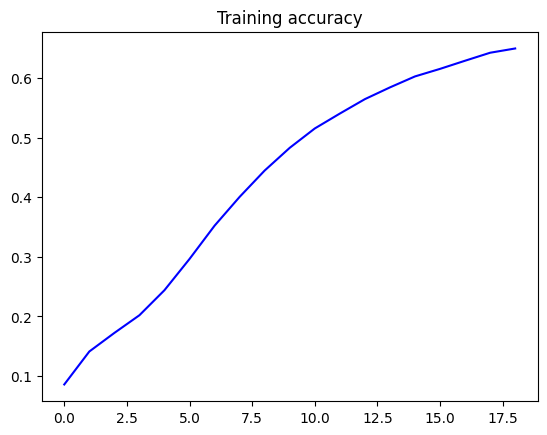

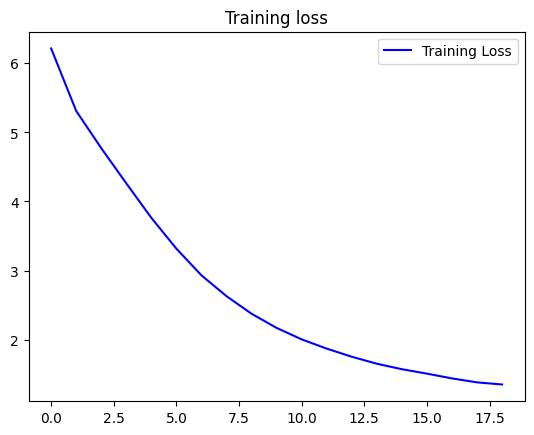

In [ ]:
# how loss and acuuracy changed while training
import matplotlib.pyplot as plt
history = model.history
acc = history.history['acc']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()